# **Booster Challenge- Etape 2 : Segmentation d’un parking.**





## Install System

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/ParkingSegmentation')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import optimizers, initializers
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D,\
    Flatten, UpSampling2D, GaussianNoise,\
    Reshape, Lambda, Add, concatenate,Conv2DTranspose,\
    Dropout, LeakyReLU, Activation, GlobalAveragePooling2D, PReLU, Softmax, Multiply
from keras.models import model_from_json, Model 
import UtilsFunction as UF
from keras_applications.resnext import ResNeXt50, ResNeXt101
from keras_applications.nasnet import NASNetLarge
from keras_applications import inception_resnet_v2
from keras_applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize, rescale

from keras.callbacks import LearningRateScheduler, EarlyStopping,\
                            ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import History

from tqdm import tqdm_notebook, tqdm

from PIL import Image, ImageDraw
from shapely.wkt import loads
from shapely.geometry import Polygon, shape, MultiPolygon
import shapely

os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.chdir('/content/drive/My Drive/ParkingSegmentation')

os.getcwd()



'/content/drive/My Drive/ParkingSegmentation'

In [0]:
import unet

## Creating Data Pickle

### Train and Validation sets

In [0]:
 # -----------------------
# Data train Import
# -----------------------
df = pd.read_csv("./Challenge_data/Hackathon-step2-Train.csv", sep=',')
image_name = df['id']
np.save('filenames.npy', image_name)

df = pd.read_csv("./Challenge_data/Hackathon-step2-Test.csv", sep=',', header=None)
image_name_test = df
np.save('filenames_test.npy', image_name_test)

filenames_shuffled = shuffle(image_name)

# saving the shuffled file.
np.save('filenames_shuffled.npy', filenames_shuffled)

filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames = train_test_split(
    filenames_shuffled_numpy, test_size=0.2, random_state=1)

print(X_train_filenames.shape)        

print(X_val_filenames.shape)               

# You can save these files as well. As you will be using them later for 
# training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)

np.save('X_val_filenames.npy', X_val_filenames)

(6631,)
(1658,)


(1001, 998, 3)


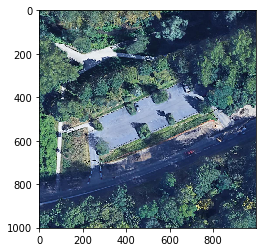

In [0]:
img = imread('./Challenge_data/NTrain/' + str(X_train_filenames[0]))
print(img.shape)
plt.imshow(img)

In [0]:
class DataBuilding() :

  def __init__(self, image_filenames) :
    self.image_filenames = image_filenames

  def __getitem__(self, size=None, name='train_%d.pickle', path='./Challenge_Data/TRAIN_Resized/', image_shape=(64, 64, 3)):
    x = self.image_filenames[:size]

    X_train = np.array([
               resize(imread(path + 'NTrain/' + str(file_name)), image_shape)
               for file_name in tqdm(x)])
    
    Y_train = np.array([
               resize(imread(path +'NTrain_mask/' + str(file_name)), (image_shape[0],image_shape[0],1))
               for file_name in tqdm(x)])

    with open(name%(size), 'wb') as f:
      pickle.dump([X_train, Y_train], f, protocol=4)

    return [X_train, Y_train]

In [0]:
Builder_train = DataBuilding(X_train_filenames)
Builder_val   = DataBuilding(X_val_filenames)

X_train, y_train = Builder_train.__getitem__(size=4000, 
                                             path='./Challenge_data/',
                                             image_shape=(256, 256, 3),
                                             name='train_%d.pickle')
X_val, y_val     = Builder_val.__getitem__(size=1600, 
                                           path='./Challenge_data/',
                                           image_shape=(256, 256, 3),
                                           name='val_%d.pickle')

100%|██████████| 1600/1600 [17:18<00:00,  1.56it/s]


## Load Data Pickle

In [0]:
with open('train_4000.pickle', 'rb') as f:
    X_train, Y_train = pickle.load(f)

with open('val_1600.pickle', 'rb') as f:
    X_val, y_val = pickle.load(f)

# Network Processing

In [0]:
def get_augmented(
    X_train, 
    Y_train, 
    X_val=None,
    Y_val=None,
    batch_size=32, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        #width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    train_generator_ = zip(X_train_augmented, Y_train_augmented)

    train_generator = (pair for pair in train_generator_)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size*2, shuffle=True, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size*2, shuffle=True, seed=seed)

        # combine generators into one which yields image and masks
        val_generator_ = zip(X_val_augmented, Y_val_augmented)

        val_generator = (pair for pair in val_generator_)
        
        return train_generator, val_generator
    else:
        return train_generator

## Building Pipeline

In [0]:
def iou_loss(y_true, y_pred, smooth=10):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def sym_dif(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.sum(y_true_f) + K.sum(y_pred_f) - 2*intersection

def loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (K.sum(y_true_f) + K.sum(y_pred_f) - 2*intersection)/100000

#### DeepLabv3+

In [8]:
from model import Deeplabv3
import tensorflow as tf
DLseg = Deeplabv3(input_shape=(256, 256, 3), 
                  classes=1, 
                  weights='cityscapes', 
                  activation='sigmoid',
                  backbone='xception')  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
166100992/166094648 [==============================] - 4s 0us/step


In [9]:
DLseg.load_weights("deeplabv3_v4.h5")#./keras4.hdf
DLseg.compile(optimizer = tf.train.AdamOptimizer(1e-4), loss = iou_loss, metrics = [iou_metric, sym_dif])
    

DLseg.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 128, 128, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

#### ResNet

In [0]:
RESseg = unet.resnet50_unet(1, input_height=256, input_width=256, encoder_level=5)

NameError: ignored

In [0]:
RESseg.compile(optimizer = optimizers.Adam(lr = 0.0004), loss = iou_loss, metrics = [iou_metric, sym_dif])
    

RESseg.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

#### VGG

In [0]:
VGGseg = unet.vgg_unet(1, input_height=256, input_width=256, encoder_level=5)





58892288/58889256 [==============================] - 1s 0us/step











In [0]:
VGGseg.compile(optimizer = optimizers.Adam(lr = 0.00003), loss = iou_loss, metrics = [iou_metric, sym_dif])
    

VGGseg.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

### First test

In [0]:
def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    count = 0
    Count = len(down_layers)
    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])

    #model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = iou_loss, metrics = [iou_metric, ])
    
    model.summary()
    return model

In [0]:
Seg = satellite_unet(input_shape=(256, 256, 3),
                      num_classes=1,
                      output_activation='sigmoid',
                      num_layers=4)


SEG.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = iou_loss, metrics = [iou_metric, sym_diff])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 256, 256, 64) 256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization_7[0][0]      
___________________________________________________________________________________________

## Train Network

In [0]:
epochs=100
batch_size=16


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras8.hdf5", save_best_only=True, verbose=1, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

In [0]:
datagen, datagen_pred = get_augmented(X_train, 
                                      Y_train, 
                                      X_val=X_val,
                                      Y_val=y_val,
                                      batch_size=batch_size, 
                                      seed=0, 
                                      data_gen_args = dict(
                                          rotation_range=0,
                                          height_shift_range=0.0,
                                          shear_range=0,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='constant'
                                      ))

In [0]:
history = DLseg.fit_generator(datagen,
                          steps_per_epoch=int(len(X_train) // 16),
                          epochs=epochs,
                          shuffle=True,
                          validation_data=datagen_pred,
                          validation_steps=int(len(X_val) // 4),
                          callbacks=[early_stopping, model_checkpoint])

In [0]:
from keras.utils import plot_model

name = 'deeplabv3+'

plot_model(DLseg, to_file='pictures/model' + name + '.png')



# Plot training & validation iou_metric values
fig = plt.figure()
plt.plot(history.history['iou_metric'])
plt.plot(history.history['val_iou_metric'])
plt.title('Model iou')
plt.ylabel('iou_metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('pictures/acc' + name + '.png')

# Plot training & validation loss values
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('pictures/loss' + name + '.png')

In [11]:
tf.keras.utils.plot_model(
    DLseg,
    to_file='pictures/model' + name + '.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.893881 to fit



In [0]:
# serialize model to JSON
model_json = DLseg.to_json()
with open("deeplabv3_v2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
DLseg.save_weights("deeplabv3_v2.h5")
print("Saved model to disk")
del model_json

In [0]:
# serialize weights to HDF5
DLseg.save_weights("deeplabv3_v5.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
pre = DLseg.predict(X_val, verbose=1)

1600/1600 [==============================] - 24s 15ms/sample


In [0]:
def iou_np(y_true, y_pred, smooth=0.01):
    intersection = y_true * y_pred
    union = y_true + y_pred
    return np.sum(intersection + smooth) / np.sum(union - intersection + smooth)

def treshold(pre, y_true):
  score = []
  for i in tqdm(np.linspace(0,1,100)):
    pred2 = pre.copy()
    pred2 = (pred2>i).astype(np.int8)
    score.append(iou_np(y_true,pred2))

  return score, np.argmax(score)/100

score, tresh = treshold(pre, y_val)

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


0.01


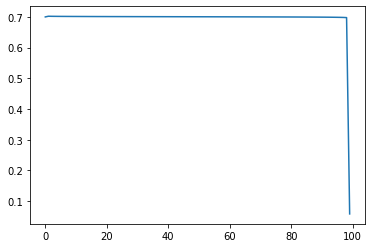

In [0]:
plt.plot(score)
print(tresh)

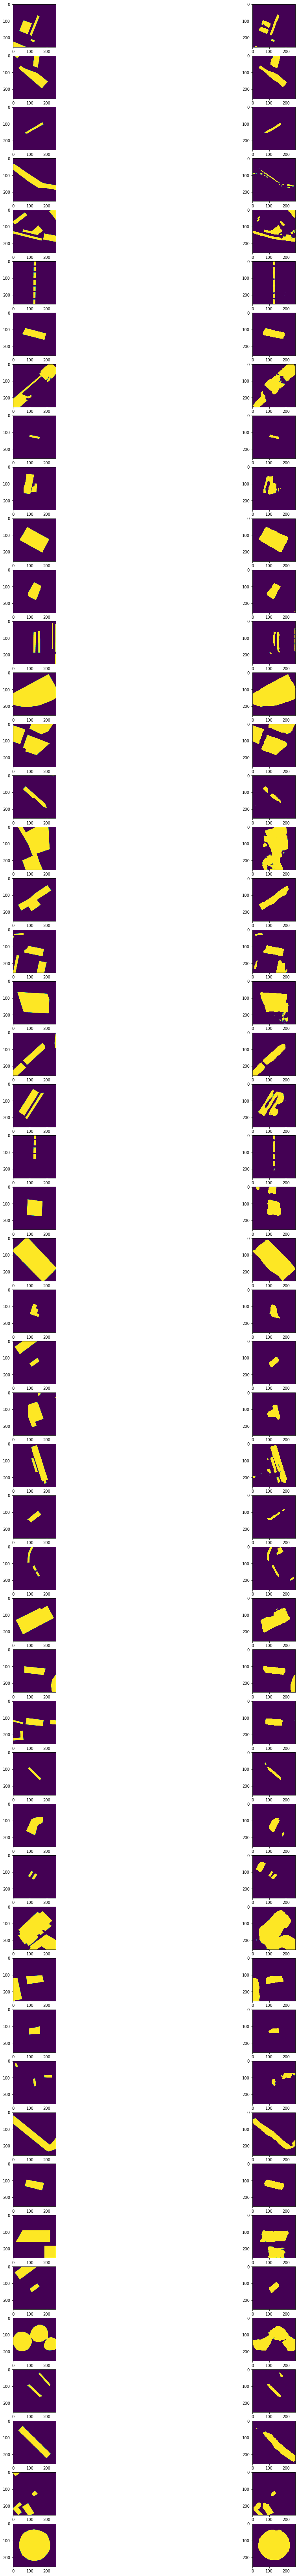

In [13]:
  input_shape=(256, 256)
  inte = np.random.randint(0, X_val.shape[0], 50)

  fig = plt.figure(figsize=(20, 120))
  for j in range(len(inte)):
      axs = fig.add_subplot(50, 2, 2*j + 1)
      plt.imshow(y_val[inte[j]].reshape(input_shape))
      axs = fig.add_subplot(50, 2, 2*j + 2)
      plt.imshow(pre[inte[j]].reshape(input_shape))
      
  fig.savefig("pictures/results_" + 'val' + ".png")

In [0]:
DLseg.evaluate(X_val, y_val, verbose=1)

1600/1600 [==============================] - 18s 11ms/sample - loss: 1.2122 - iou_metric: 0.6828 - sym_dif: 121215.9219


[1.2121593344211579, 0.68275964, 121215.92]

In [0]:
!pip install rasterio
!pip install imantics
import imantics
import rasterio
import shapely

     |████████████████████████████████| 18.0MB 199kB/s 
  Created wheel for imantics: filename=imantics-0.1.11-cp36-none-any.whl size=15832 sha256=1dab041334bdc6dd086c208f6fbd52b780045a9c85af7f42724f2f6bf6eea6d9
  Stored in directory: /root/.cache/pip/wheels/da/f0/b4/46ff625a34d2841fe55668a3052c246c0fec68709319dee8ee
Successfully built imantics


In [0]:
from imantics import Polygons, Mask
from shapely.geometry import Polygon, MultiPolygon, LinearRing

def mask2poly(Masks):
  POLYGONS = []
  for i in tqdm(range(Masks.shape[0])):
    mask = (Masks[i]>0.11).astype(np.int8)

    polygons = Mask(mask).polygons()

    points = polygons.points

    poly = []
    Area = []
    for point in points:
      x = point[:,0]
      y = point[:,1]

      if len(x)>2:
        coords = zip(x,y)
        p = Polygon(coords).buffer(0)
        if p.type.upper()=="MULTIPOLYGON":
            poly.append(p[0])
            Area.append(poly[-1].area)
        else:
            poly.append(p)
            Area.append(poly[-1].area)

    if len(poly)==0:
      mini_mask = np.zeros((1000,1000, 1))
      mini_mask[500, 500:502] = 1
      mini_mask[501, 500:501] = 1

      polygons = Mask(mini_mask).polygons()

      points = polygons.points

      poly = []
      Area = []
      for point in points:
        x = point[:,0]
        y = point[:,1]

        if len(x)>2:
          coords = zip(x,y)
          p = Polygon(coords).buffer(0)
          if p.type.upper()=="MULTIPOLYGON":
              poly.append(p[0])
              Area.append(poly[-1].area)
          else:
              poly.append(p)
              Area.append(poly[-1].area)

    r = pd.DataFrame(poly)
    r.columns = ['poly']
    r['Aera'] = Area

    r = r.sort_values(by=['Aera'], ascending=False)
    poly = list(r['poly'].values)

    new_poly = []
    i=0
    while i<len(poly):
        temp = poly[i].buffer(0)
        j = i+1
        while j<len(poly):
            if poly[i].contains(poly[j]):
                ext = temp
                inte = temp.interiors[:]
                a = [inner for inner in inte]
                a.append(LinearRing(list(poly[j].exterior.coords[:])))
                inte = a
                temp = Polygon(ext.exterior.coords[:], inte)
                poly.remove(poly[j])
            else:
                j+=1
        i+=1
        new_poly.append(temp)
        
    m = MultiPolygon(new_poly)
    POLYGONS.append(str(m.buffer(0).wkt))
  return POLYGONS

In [0]:
M = mask2poly(pre)

100%|██████████| 1600/1600 [00:05<00:00, 318.86it/s]


In [0]:
M

['POLYGON ((49 40, 48 41, 46 41, 43 44, 43 53, 44 54, 44 56, 45 57, 45 63, 46 64, 46 65, 45 66, 45 89, 44 90, 44 93, 43 94, 43 96, 42 97, 42 100, 41 101, 41 107, 40 108, 40 115, 39 116, 39 121, 38 122, 38 125, 37 126, 37 127, 36 128, 36 130, 33 133, 32 133, 30 135, 29 135, 28 136, 27 136, 26 137, 24 137, 23 138, 20 138, 18 140, 17 140, 16 141, 14 141, 13 142, 10 142, 9 143, 8 143, 7 144, 6 144, 5 145, 2 145, 0 147, 0 255, 28 255, 30 253, 30 252, 31 251, 31 250, 33 248, 33 247, 34 246, 34 245, 40 239, 41 239, 44 236, 45 236, 53 228, 54 228, 56 226, 56 224, 57 223, 57 209, 56 208, 56 205, 55 204, 55 199, 61 193, 62 193, 63 192, 64 192, 66 190, 67 190, 68 189, 70 189, 71 190, 72 190, 73 191, 74 191, 77 194, 78 193, 79 193, 80 192, 81 192, 83 190, 84 190, 86 188, 87 188, 88 187, 89 187, 92 184, 93 184, 95 182, 96 182, 99 179, 100 179, 101 178, 102 178, 104 176, 105 176, 106 175, 107 175, 108 174, 109 174, 111 172, 112 172, 113 171, 114 171, 115 170, 118 170, 119 169, 121 169, 122 168, 124 

# Predict on test

## Load data

In [0]:
# -----------------------
# Data test Import
# -----------------------
df = pd.read_csv("./Challenge_data/Hackathon-step2-Test.csv", sep=',', header=None)
image_name_test = df[0].values
np.save('filenames_test.npy', image_name_test)

In [0]:
class DataBuilding() :

  def __init__(self, image_filenames) :
    self.image_filenames = image_filenames

  def __getitem__(self, size=None, name='train_%d.pickle', path='./Challenge_Data/TRAIN_Resized/', image_shape=(64, 64, 3)):
    x = self.image_filenames#[:size]

    X_train = np.array([
               resize(imread(path + 'NTest/' + str(file_name)), image_shape)
               for file_name in tqdm(x)])
    
    o_size = np.array([
               imread(path + 'NTest/' + str(file_name)).shape[:2]
               for file_name in tqdm(x)])

    with open(name%(size), 'wb') as f:
      pickle.dump([X_train, o_size], f, protocol=4)

    return [X_train, o_size]

In [0]:
Builder_test   = DataBuilding(image_name_test)

X_test, o_size = Builder_test.__getitem__(size=2073, 
                                             path='./Challenge_data/',
                                             image_shape=(256, 256, 3),
                                             name='test_%d.pickle')

100%|██████████| 2073/2073 [00:34<00:00, 57.17it/s]


In [0]:
with open('test_2073.pickle', 'rb') as f:
    X_test, o_size = pickle.load(f)

## Load model

In [0]:
# load json and create model
json_file = open('unet_resnet_v1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
RESseg = model_from_json(loaded_model_json)
# load weights into new model
RESseg.load_weights("unet_resnet_v1.h5")
print("Loaded model from disk")




RESseg.compile(optimizer = optimizers.Adam(lr = 0.0004), loss = iou_loss, metrics = [iou_metric, sym_dif])

Loaded model from disk



### Predict

In [15]:
pre = DLseg.predict(X_test, verbose=1)

2073/2073 [==============================] - 20s 10ms/sample


In [0]:
def _resize(pre=None, o_size=None):
  pred = np.array([
               resize(pre[i], o_size[i])
               for i in tqdm(range(pre.shape[0]))])
  return pred

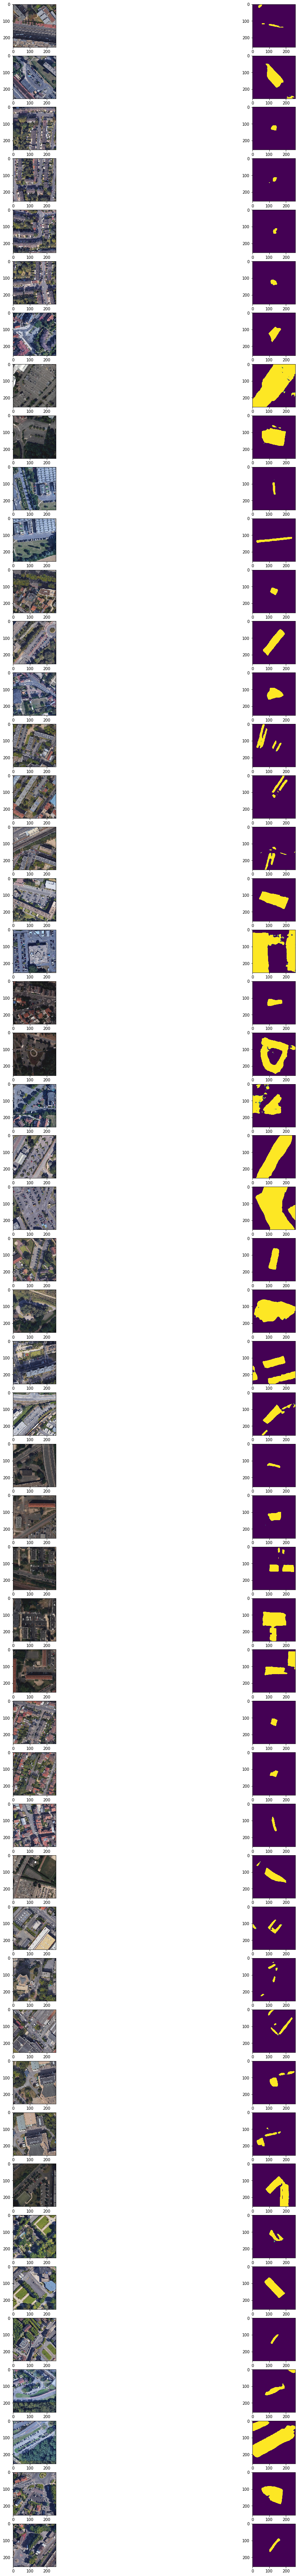

In [16]:
input_shape=(256, 256)
inte = np.linspace(0, 49, 50).astype(int)

fig = plt.figure(figsize=(20, 120))
for j in range(len(inte)):
    axs = fig.add_subplot(50, 2, 2*j + 1)
    plt.imshow(X_test[inte[j]].reshape(256, 256, 3))
    axs = fig.add_subplot(50, 2, 2*j + 2)
    plt.imshow(pre[inte[j]].reshape(input_shape))

fig.savefig("pictures/results_" + 'test' + ".png")

In [0]:
pre2 = _resize(pre=pre, o_size=o_size)
del pre

100%|██████████| 2073/2073 [02:10<00:00,  9.25it/s]


In [0]:
M = mask2poly(pre2)

df = pd.read_csv("./Challenge_data/Hackathon-step2-Test.txt", sep=';')
image_name_test = df['id'].values

output = pd.DataFrame(image_name_test)
output.columns = ['id']

output['polygon'] = M

missing = pd.DataFrame(np.array(['100052660_RGB.tif']))
missing.columns = ['id']

mask = np.zeros((256*256)).reshape(1, 256, 256, 1)

missing['polygon'] = mask2poly(mask)

output = missing.append(output)

print(output.dtypes)

output.to_csv('output.csv', index=False, sep=';')

100%|██████████| 1/1 [00:00<00:00, 113.97it/s]


id         object
polygon    object
dtype: object


In [0]:
output

id                                            polygon
0     100052660_RGB.tif     POLYGON ((500 500, 500 501, 501 500, 500 500))
0     100052666_RGB.tif  MULTIPOLYGON (((399 463, 397 465, 396 465, 395...
1     100129236_RGB.tif  MULTIPOLYGON (((902 936, 902 937, 901 938, 900...
2     100796980_RGB.tif  POLYGON ((504 438, 503 439, 485 439, 484 440, ...
3     100796984_RGB.tif  MULTIPOLYGON (((504 452, 504 453, 503 454, 502...
...                 ...                                                ...
2068   98546417_RGB.tif  POLYGON ((633 184, 632 185, 623 185, 622 186, ...
2069   99001252_RGB.tif  POLYGON ((473 361, 473 363, 471 365, 469 365, ...
2070   99027411_RGB.tif  MULTIPOLYGON (((680 395, 679 396, 669 396, 668...
2071   99699181_RGB.tif  POLYGON ((586 451, 584 453, 583 453, 582 454, ...
2072   99863100_RGB.tif  POLYGON ((520 484, 519 485, 517 485, 516 486, ...

[2074 rows x 2 columns]

In [0]:
pd.read_csv('output.csv', sep=';')

id                                            polygon
0     100052660_RGB.tif     POLYGON ((500 500, 500 501, 501 500, 500 500))
1     100052666_RGB.tif  MULTIPOLYGON (((399 463, 397 465, 396 465, 395...
2     100129236_RGB.tif  MULTIPOLYGON (((902 936, 902 937, 901 938, 900...
3     100796980_RGB.tif  POLYGON ((504 438, 503 439, 485 439, 484 440, ...
4     100796984_RGB.tif  MULTIPOLYGON (((504 452, 504 453, 503 454, 502...
...                 ...                                                ...
2069   98546417_RGB.tif  POLYGON ((633 184, 632 185, 623 185, 622 186, ...
2070   99001252_RGB.tif  POLYGON ((473 361, 473 363, 471 365, 469 365, ...
2071   99027411_RGB.tif  MULTIPOLYGON (((680 395, 679 396, 669 396, 668...
2072   99699181_RGB.tif  POLYGON ((586 451, 584 453, 583 453, 582 454, ...
2073   99863100_RGB.tif  POLYGON ((520 484, 519 485, 517 485, 516 486, ...

[2074 rows x 2 columns]